In [1]:
import tensorflow as tf
from tensorflow.python.ops.rnn import _transpose_batch_time
from model import sampling_rnn
import numpy as np
import pandas as pd
import copy
import time
import glob, os, sys

from helpers import get_sequences, iterate_minibatches, get_minibatches, check_game_roles_duplicates
    
import matplotlib.pyplot as plt

# import os
# os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

%matplotlib inline

from utilities import LoadData, PlotGame, make_video
from helpers import id_player, id_position, id_teams, get_player_trajectory, segment
from model import rnn_horizon
# ---------------------------------------------------------
%load_ext autoreload
%autoreload 2

# ---------------------------------------------------------
# directories
main_dir = '../'
game_dir = main_dir+'data/'
Data = LoadData(main_dir, game_dir)

/home/sam/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/sam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# we will use this fixed order as the role order
roles = ['F', 'G', 'C-F', 'G-F', 'F-G', 'C', 'F-C']
role_order = {'F': 0, 'G':4, 'C-F':1, 'G-F':3, 'F-G':3, 'C':2, 'F-C':1}
# its possible that F has similar role as G-f or F-G, we create empty slots to ensure meta order

In [3]:
%%time
game_id = '0021500463'
game_data = Data.load_game(game_id)
events = pd.DataFrame(game_data['events'])

CPU times: user 11 s, sys: 124 ms, total: 11.1 s
Wall time: 11 s


### Let's just see the forward role model first, and ignore defending vs offending, use home vs visitor
### also ignore sequence length

In [40]:
id_role

{2200: ['C-F'],
 2449: ['F'],
 2550: ['G'],
 200768: ['G'],
 201166: ['G'],
 201565: ['G'],
 201942: ['G'],
 201949: ['F'],
 201959: ['F'],
 201960: ['F'],
 202335: ['F'],
 202685: ['C'],
 202687: ['C-F'],
 202703: ['F'],
 202709: ['G'],
 202710: ['G-F'],
 202734: ['G'],
 203082: ['F-G'],
 203461: ['F'],
 203503: ['F'],
 203512: ['C'],
 203926: ['F'],
 203946: ['F-C'],
 1626153: ['G'],
 1626171: ['F'],
 1626245: ['F-C']}

In [4]:
id_role = id_position(events)
check_game_roles_duplicates(id_role)

0

In [5]:
homeid = events.loc[0].home['teamid']
awayid = events.loc[0].visitor['teamid']

In [6]:
events.loc[0].home['name']

'Chicago Bulls'

In [7]:
game_data['gamedate']

'2015-12-28'

In [8]:
len(events.loc[0,'moments'])

150

In [9]:
events['moments'].apply(lambda x: len(x)).values.min()

6

In [11]:
# a = events.loc[0,'moments']
# # print(len(a), len(a)*10*2*5)
# e0 = process_moments(a)

In [12]:
events.loc[221, :].home['teamid']

1610612741

In [13]:
events.moments[221][29]

[4,
 1451358777223,
 63.0,
 None,
 None,
 [[-1, -1, 75.46226, 24.81421, 2.9923],
  [1610612741, 2200, 85.16542, 14.22962, 0.0],
  [1610612741, 201166, 66.30584, 17.15957, 0.0],
  [1610612741, 202710, 87.15369, 33.42979, 0.0],
  [1610612741, 203503, 82.85255, 33.22433, 0.0],
  [1610612761, 201960, 84.78216, 33.17034, 0.0],
  [1610612761, 200768, 74.49802, 25.36242, 0.0],
  [1610612761, 201942, 57.10716, 29.50134, 0.0],
  [1610612761, 203082, 64.77583, 19.00113, 0.0]]]

In [14]:
events.shape

(231, 8)

In [15]:
# e0.shape

In [16]:
%%time
homeid = events.loc[0].home['teamid']
awayid = events.loc[0].visitor['teamid']
single_game = []
len_th = 10
n = 0
n_short = 0
for k, v in enumerate(events.moments.values):
    print('>>>>>>>', k, end='\r')
    pm = process_moments(v,homeid, awayid)
    if pm.shape[0] >= len_th:
        single_game.append(pm)
        n += 1
    else:
        n_short += 1
print(n, n_short)
# dimensions extreme<3> x n_players<10> x (player_pos<2> + teamid_onehot<25> + ball<3>) = 900

Warning!: There are less than 10 players! (skip)
Warning!: There are less than 10 players! (skip)
Warning!: There are less than 10 players! (skip)
230 1>> 230
CPU times: user 2min 37s, sys: 1.22 s, total: 2min 39s
Wall time: 2min 38s


In [17]:
single_game[0].shape

(150, 900)

In [18]:
# lets first predict role F (ignored the extreme)
game_target = [np.roll(i[:, :2], -1, axis=0) for i in single_game]

In [19]:
# D = 900
single_game[0].shape

(150, 900)

In [20]:
game_target[0].shape

(150, 2)

In [21]:
single_game[1].shape

(550, 900)

#### create train and test set

In [22]:
p = 0.8 # train percentage
divider = int(len(single_game)*p)
train_game, test_game = single_game[:divider], single_game[divider:]
train_target, test_target = game_target[:divider], game_target[divider:]

In [23]:
# single_game[0]
# seq_len = 10
# batch_size = 32

In [24]:
# # train x
# train_x = [get_sequences(i, seq_len, D) for i in single_game]
# train_x = np.concatenate(train_x, axis=0)
# # train y
# train_y = [get_sequences(i, seq_len, 2) for i in game_target]
# train_y = np.concatenate(train_y, axis=0)

# train_x_batches, train_y_batches = get_minibatches(train_x, train_y, batch_size) 
# train_x_batches.shape

In [25]:
# train_x_batches.shape

In [27]:
# train_y_batches.shape

In [28]:
%%time
tf.reset_default_graph()

batch_size = 32
state_size = 512
dimx = 900
dimy = 2

# cell
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(state_size, forget_bias=1.)
# initial state
initial_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)

# input 
h = tf.placeholder(tf.int32)
X = tf.placeholder(tf.float32, [batch_size, None, dimx], name = 'train_input')
Y = tf.placeholder(tf.float32, [batch_size, None, dimy], name = 'train_label')
output, last_states = rnn_horizon(cell=lstm_cell, 
                                  initial_state=initial_state, 
                                  input_=X,
                                  batch_size=batch_size,
                                  seq_lengths=h,
                                  output_dim=dimy)
# output as the prediction
print('output shape, last_states', output.shape, last_states)
pred = output
print('=================label shape:{0:} | output prediction shape: {1:}'.format(Y.shape, pred.shape))

# loss
loss = tf.losses.mean_squared_error(Y, pred)
# optimzier
opt = tf.train.AdamOptimizer().minimize(loss)
# session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Initializing the variables
sess.run(tf.global_variables_initializer())
# iterate
printn = int(1e2)
horizon = 6
t_int = time.time()
for k in range(1, horizon+1):
    print('Horizon {0:} {1:}'.format(k+1, '='*10))
    # look-ahead horizon
    seq_len = k + 1

    # train x
    train_x = copy.deepcopy([get_sequences(i, seq_len, dimx) for i in train_game])
    train_x = copy.deepcopy(np.concatenate(train_x, axis=0))
    print('train_x.shape:', train_x.shape)
    # train y
    train_y = copy.deepcopy([get_sequences(i, seq_len, dimy) for i in train_target])
    train_y = copy.deepcopy(np.concatenate(train_y, axis=0))
    print('train_y.shape:', train_y.shape)
    for i in range(1000):
        epoch_loss =0.
        t1 = time.time()
        for batch in iterate_minibatches(train_x, train_y, batch_size, shuffle=False):
            train_xi, train_yi = batch
            p, l, _ = sess.run([output, loss, opt], feed_dict={X: train_xi, Y: train_yi, h:seq_len})
            epoch_loss += l
        # print out info
        if i%printn ==0:
            print('Epoch {0:<4d} | loss: {1:<8.2f} | time took: {2:<.2f}s'.format(i, epoch_loss, (time.time()-t1)))
t_end = time.time()
print('Total time took: {0:<.2f}hrs'.format((time.time()-t_int)/60/60))
    
# # save model
# #Create a saver object which will save all the variables
# saver = tf.train.Saver()
# #save the graph
# saver.save(sess, save_path='./models/test_model')

output shape, last_states (32, ?, 2) LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(32, 512) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(32, 512) dtype=float32>)
=================label shape:(32, ?, 2) | output prediction shape: (32, ?, 2)
Horizon 2 ==========
train_x.shape: (40811, 2, 900)
train_y.shape: (40811, 2, 2)
Epoch 0    | loss: 685625.40 | time took: 4.03s
Epoch 100  | loss: 44254.32 | time took: 3.75s
Epoch 200  | loss: 36855.37 | time took: 3.74s
Epoch 300  | loss: 31437.44 | time took: 3.75s
Epoch 400  | loss: 29413.20 | time took: 3.75s
Epoch 500  | loss: 24855.36 | time took: 3.72s
Epoch 600  | loss: 22850.95 | time took: 3.75s
Epoch 700  | loss: 22226.04 | time took: 3.73s
Epoch 800  | loss: 22356.08 | time took: 3.73s
Epoch 900  | loss: 18407.11 | time took: 3.74s
Horizon 3 ==========
train_x.shape: (27179, 3, 900)
train_y.shape: (27179, 3, 2)
Epoch 0    | loss: 15266.28 | time took: 3.16s
Epoch 100  | loss: 12160.53 | time took: 3.14s
Epoch 200  

### Check model on train set

In [29]:
check_seq_len = 3
check_ind = np.random.randint(0, len(train_game)-1)
check_ind = 0
print('check_id:', check_ind)
input_x = copy.deepcopy(get_sequences(train_game[check_ind], check_seq_len, dimx))
output_y = copy.deepcopy(get_sequences(train_target[check_ind], check_seq_len, dimy))
pred = []
y_train = []
order_x = []
for batch in iterate_minibatches(input_x, output_y, batch_size, shuffle=False):
    input_xi, output_yi = batch
    p = sess.run([output], feed_dict={X: input_xi, h:check_seq_len})#, Y: train_yi, h:2})
    pred.append(p)
    order_x.append(input_xi)
    y_train.append(output_yi)
pred_train = np.array(pred).reshape(-1,2)
y_train = np.array(y_train).reshape(-1,2)

check_id: 0


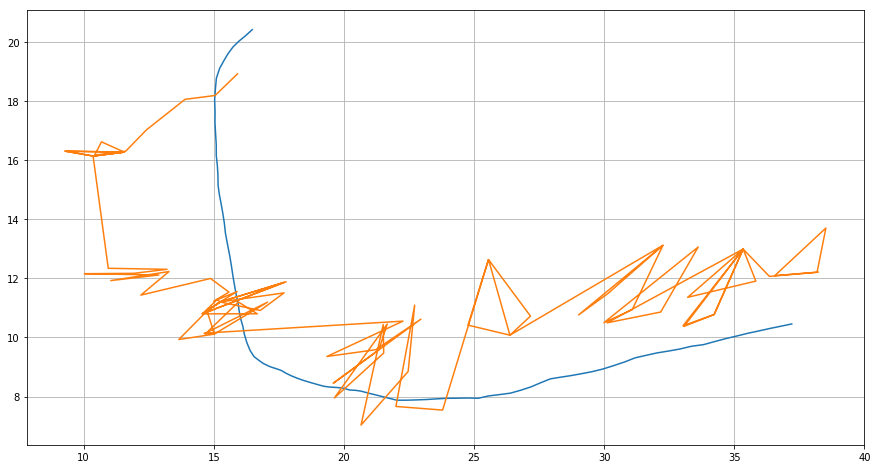

In [30]:
plt.figure(figsize=(15,8))
plt.plot(y_train[:,0], y_train[:,1], pred_train[:, 0], pred_train[:, 1])
plt.grid(True)

#### Check model on test set

In [31]:
check_ind = np.random.randint(0, len(test_game)-1)
input_x = copy.deepcopy(get_sequences(test_game[check_ind], check_seq_len, dimx))
output_y = copy.deepcopy(get_sequences(test_target[check_ind], check_seq_len, dimy))
pred = []
y_test = []
for batch in iterate_minibatches(input_x, output_y, batch_size, shuffle=False):
    input_xi, output_yi = batch
    p = sess.run([output], feed_dict={X: input_xi, h:check_seq_len})#, Y: train_yi, h:2})
    pred.append(p)
    y_test.append(output_yi)
pred_test = np.array(pred).reshape(-1,2)
y_test = np.array(y_test).reshape(-1,2)

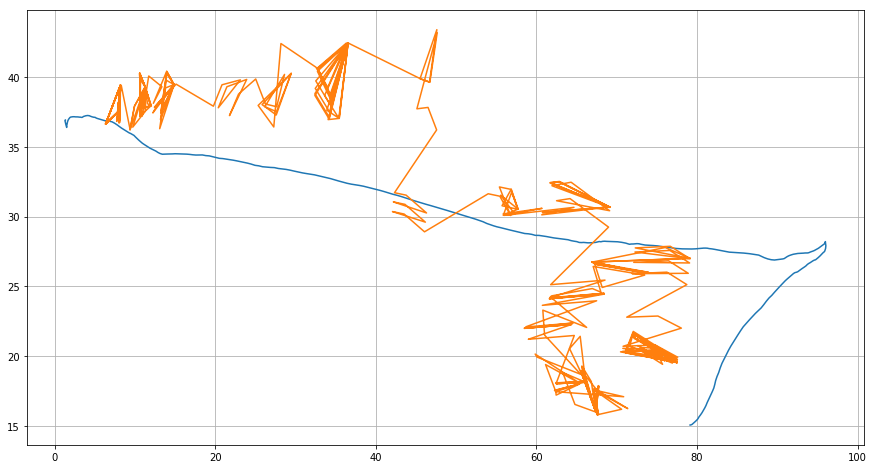

In [32]:
plt.figure(figsize=(15,8))
plt.plot(y_test[:,0], y_test[:,1], pred_test[:, 0], pred_test[:, 1])
plt.grid(True)

#### Create video based off predictions

In [33]:
# events.head()
# replace the true position with the predicted
events_pred = events.head(1).copy()
def replace_pos(x):
    for i in range(len(pred_train)):
#         print(x[i][5])
#         print(x[i][5][2][2:4], pred_train[i])
        x[i][5][2][2:4]=pred_train[i] 
events_pred = events_pred.moments.apply(lambda x: replace_pos(x))

In [34]:
# save all moments for a specific events
Plot = PlotGame(game_id, main_dir, game_dir)
moments = range(len(pred_train))
event_number = 0
for i in moments:
    print(i, end='\r')
    Plot.load_pred_moment2img(game_data, event_number, i)
# PlotGame.load_pred_moment2img()

In [35]:
#  so by comparing the position we know we are modelling the third position ind = 2
# order_x

In [36]:
# prepare to save videos
event_dir = game_dir + 'game' + str(game_id) + '/' + 'predevent' + str(event_number) + '/'
video_name = event_dir + str(event_number) + '.mp4'
print(video_name)
images = glob.glob(event_dir + "*.png")
images = sorted(images, key=lambda x: int(x.split('.')[2].split('/')[-1][4:]))
# print(images)
# save to video
make_video(images, video_name, 15)

../data/game0021500463/predevent0/0.mp4
The output video is ../data/game0021500463/predevent0/0.mp4


In [37]:
pred_train.shape

(96, 2)

In [39]:
# len(events_pred.moments)